# 0. Setup

In [1]:
# Verify we're in the correct working directory
import os
import git 
from pathlib import Path

def get_project_root():
    return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

root = get_project_root()

os.chdir(root)
os.getcwd()

'/Users/seraphinashi/Desktop/DataFusion/DrugResponse_Omics_Molecules'

In [2]:
plot_folder = "results/images/simulations/"

## import packages, models, trainers

In [3]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

/Users/seraphinashi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


pytorch version: 1.13.1
orig num threads: 4


In [4]:
from models import *
from trainers import *
from losses import *
from utils import *

In [5]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [6]:
simu_folder = "data/simulations"
RNAseq = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq.csv"), index_col = 0)
RNAseq_meta = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq_meta.csv"), index_col = 0)
d_fp = pd.read_csv(os.path.join(simu_folder, "simu2_d_fp.csv"), index_col = 0)
cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr.csv"), index_col = 0)

In [7]:
RNAseq_meta['C_type'] = RNAseq_meta['C_type'].replace('grp3', 'grp0')

In [8]:
c_data = RNAseq.T

# originally
c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)

print(f"Cancer type coding map: ")
print(meta_map)

d_data = d_fp.T

cdr = cdr
cdr.index = cdr.index.astype("str")

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
4   grp1     1     35
8   grp2     2     41


In [9]:
num_cluster = 3

# only two groups
two_grp = False
if two_grp:
    num_cluster = 2
    RNAseq_meta.loc[RNAseq_meta.C_type=='grp2', 'C_type'] = 'grp1'
    
    c_meta_true = c_meta
    c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)
    print(f"Cancer type coding map: ")
    print(meta_map)

## Train & Test split

In [10]:
c_train, c_test = train_test_split(c_data, test_size=0.15)

c_meta_train = get_CCL_meta(c_train.index.values, c_meta)
c_meta_test = get_CCL_meta(c_test.index.values, c_meta)

cdr_train_idx = np.isin(cdr.index.values, c_train.index.values)
cdr_train = cdr[cdr_train_idx]
cdr_test = cdr[~cdr_train_idx]

if two_grp:
    c_meta_train_true = get_CCL_meta(c_train.index.values, c_meta_true)
    c_meta_test_true = get_CCL_meta(c_test.index.values, c_meta_true)

In [11]:
print(f"Training data: \n   cdr: {cdr_train.shape}\n   c_data: {c_train.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_train_true['code'], c_meta_train['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_train['code'].value_counts())

print(f"\nTesting data:  \n   cdr: {cdr_test.shape}\n   c_data: {c_test.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_test_true['code'], c_meta_test['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_test['code'].value_counts())


Training data: 
   cdr: (117, 30)
   c_data: (117, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code
0    54
2    33
1    30
Name: count, dtype: int64

Testing data:  
   cdr: (21, 30)
   c_data: (21, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code
0    8
2    8
1    5
Name: count, dtype: int64


# 2. Hyperparameters

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [13]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.2 #@param {type: "float"}

    n_epochs = 100 #@param {type: "integer"}
    batch_size = 50 #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    C_VAE_loss_weight = 0.2 #@param {type: "float"}
    C_recon_loss_weight = 1 #@param {type: "float"}
    C_kld_weight = 1 #@param {type: "float"}
    C_cluster_distance_weight = 150 #@param {type: "float"}
    C_update_ratio_weight = 100 #@param {type: "float"}
    
    D_VAE_loss_weight = 0.5 #@param {type: "float"}
    D_recon_loss_weight = 1.5 #@param {type: "float"}
    D_kld_weight = 1 #@param {type: "float"}
    D_cluster_distance_weight = 100 #@param {type: "float"}
    D_update_ratio_weight = 100 #@param {type: "float"}
    
    predict_loss_weight = 1000 #@param {type: "float"}
    
    cVAE_save_path = 'data/model_fits/GDSC_simu_3c_c_vae' #@param
    dVAE_save_path = 'data/model_fits/GDSC_simu_3c_d_vae' #@param
    
    c_p_save_path = 'data/model_fits/GDSC_simu_3c_c_vae_predictor' #@param
    d_p_save_path = 'data/model_fits/GDSC_simu_3c_d_vae_predictor' #@param
    

class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [64] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 16 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}
    
    # sensitive threshold
    sens_cutoff = 0.5


In [14]:
train_args = Train_Args()

K = len(c_meta['code'].unique())

CDPmodel_args = CDPModel_sub_Args()
CDPmodel_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_args['d_input_dim'] = d_data.shape[1]

if CDPmodel_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feature number not specified''')
if CDPmodel_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [15]:
CDPmodel = CDPmodel(K, CDPmodel_args)

n_rounds = 2
returns = CDPmodel.fit(c_train, c_meta_train, d_data, cdr_train, train_args, n_rounds=n_rounds, device = device)
c_meta, c_meta_hist, d_sens_hist, losses_train_hist_list, best_epos_list, C_VAE_init_losses, D_VAE_init_losses, c_latent_list, d_latent_list = returns

=> Initialize C-VAE:
        Best epoc with test loss: epoch 93
        Running time: 0.5331308841705322
=> Initialize D-VAE:
        Best epoc with test loss: epoch 53
        Running time: 0.21643924713134766
=> round 0 <==================================
------------k = 0-------------------
 - Training CDP model with k = 0
   a. Training D_VAE and Predictor
        Best epoc with test loss: epoch 50
        Running time: 18.11474084854126
   b. 10 sensitive drug(s)
   c. Training C_VAE and Predictor
        Best epoc with test loss: epoch 90
        Running time: 13.07844877243042
   d. 54 cancer cell line(s) in the cluster
------------k = 1-------------------
 - Training CDP model with k = 1
   a. Training D_VAE and Predictor
        Best epoc with test loss: epoch 85
        Running time: 10.444159030914307
   b. 10 sensitive drug(s)
   c. Training C_VAE and Predictor
        Best epoc with test loss: epoch 93
        Running time: 13.56934118270874
   d. 30 cancer cell line(s) in

In [16]:
import torch
import numpy as np

# Sample multiple string lists with duplicates
string_list1 = ["apple", "banana", "cherry", "date"]
string_list2 = ["banana", "date", "fig", "grape"]

# Aggregate all unique strings from the multiple lists
all_strings = list(set(string_list1))

print(all_strings)

# Create a dictionary to map strings to one-hot indices
string_to_index = {string: index for index, string in enumerate(all_strings)}
print(string_to_index)

['cherry', 'banana', 'apple', 'date']
{'cherry': 0, 'banana': 1, 'apple': 2, 'date': 3}


In [17]:
import torch
import numpy as np

# Sample multiple string lists with duplicates
string_list1 = ["apple", "banana", "cherry", "date"]
string_list2 = ["banana", "date", "fig", "grape"]

# Aggregate all unique strings from the multiple lists
all_strings = list(set(string_list1 + string_list2))

# Create a dictionary to map strings to one-hot indices
string_to_index = {string: index for index, string in enumerate(all_strings)}
print(string_to_index)

# Function to perform one-hot encoding for a string list
def one_hot_encode(string_list):
    encoded_strings = []
    for string in string_list:
        encoded_strings.append(string_to_index[string])
    return encoded_strings

# Perform one-hot encoding for each list
encoded_list1 = one_hot_encode(string_list1)
encoded_list2 = one_hot_encode(string_list2)
print(encoded_list1)

# Convert the encoded lists into Torch tensors
tensor_list1 = torch.tensor(encoded_list1, dtype=torch.float32)
tensor_list2 = torch.tensor(encoded_list2, dtype=torch.float32)

print("Tensor for string_list1:")
print(tensor_list1)

print("Tensor for string_list2:")
print(tensor_list2)

{'apple': 0, 'date': 1, 'fig': 2, 'cherry': 3, 'banana': 4, 'grape': 5}
[0, 4, 3, 1]
Tensor for string_list1:
tensor([0., 4., 3., 1.])
Tensor for string_list2:
tensor([4., 1., 2., 5.])


# 4. Results and visualizations

## 4.1. Prediction:

### Training data:

In [18]:
cdr_train_hat = CDPmodel.predict(c_train, d_data)

cdr_train_rslt = cdr_train.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

In [19]:
# Binary cross entropy
cdr_train_rslt_noNA = cdr_train_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_train = log_loss(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_train}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
conf_matrix = confusion_matrix(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")

Binary cross entropy: 6.715807704032544
ROC AUC: 0.6545890861275476


ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Testing data

In [ ]:
cdr_test_hat = CDPmodel.predict(c_test, d_data)

cdr_test_rslt = cdr_test.copy()
cdr_test_rslt['c_name'] = cdr_test_rslt.index.values
cdr_test_rslt = pd.melt(cdr_test_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_test_rslt = cdr_test_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_test_rslt = pd.merge(cdr_test_rslt, cdr_test_hat, on=['c_name', 'd_name'], how='outer')

In [ ]:
# Binary cross entropy
cdr_test_rslt_noNA = cdr_test_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_test = log_loss(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_test}")

# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
cdr_test_rslt_noNA['cdr_hat_bnr'] = (cdr_test_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")


## 4.2. Clustering
### Trainning data

In [ ]:
c_meta_train_tmp = c_meta_train.loc[:, ['code']]
c_meta_train_tmp['c_name'] = c_meta_train_tmp.index.values.astype(str)
c_meta_train_tmp = c_meta_train_tmp.rename(columns={'code':'cluster_init'})

cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_train_rslt_cluster['cluster_true'], cdr_train_rslt_cluster['cluster_init']], cdr_train_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['cluster']))

In [ ]:
print('Cancer clustering before:')
print(c_meta_hist.code.value_counts())
print('Cancer clustering after:')
print(c_meta_hist.code_latest.value_counts())

In [ ]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_latest.value_counts())

### Testing data

In [ ]:
c_meta_test_tmp = c_meta_test.loc[:, ['code']]
c_meta_test_tmp['c_name'] = c_meta_test_tmp.index.values.astype(str)
c_meta_test_tmp = c_meta_test_tmp.rename(columns={'code':'cluster_init'})

cdr_test_rslt_tmp = cdr_test_rslt[['c_name', 'cluster']]
cdr_test_rslt_tmp = cdr_test_rslt_tmp.drop_duplicates()
cdr_test_rslt_tmp['c_name'] = cdr_test_rslt_tmp['c_name'].astype(str)


cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_tmp, c_meta_test_tmp, on='c_name', how='left')

pd.crosstab(cdr_test_rslt_cluster['cluster_init'], cdr_test_rslt_cluster['cluster'])

In [ ]:
if two_grp:
    cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_test_rslt_cluster['cluster_true'], cdr_test_rslt_cluster['cluster_init']], cdr_test_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_test_rslt_cluster['cluster_init'], cdr_test_rslt_cluster['cluster']))
    

## Visualizations

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

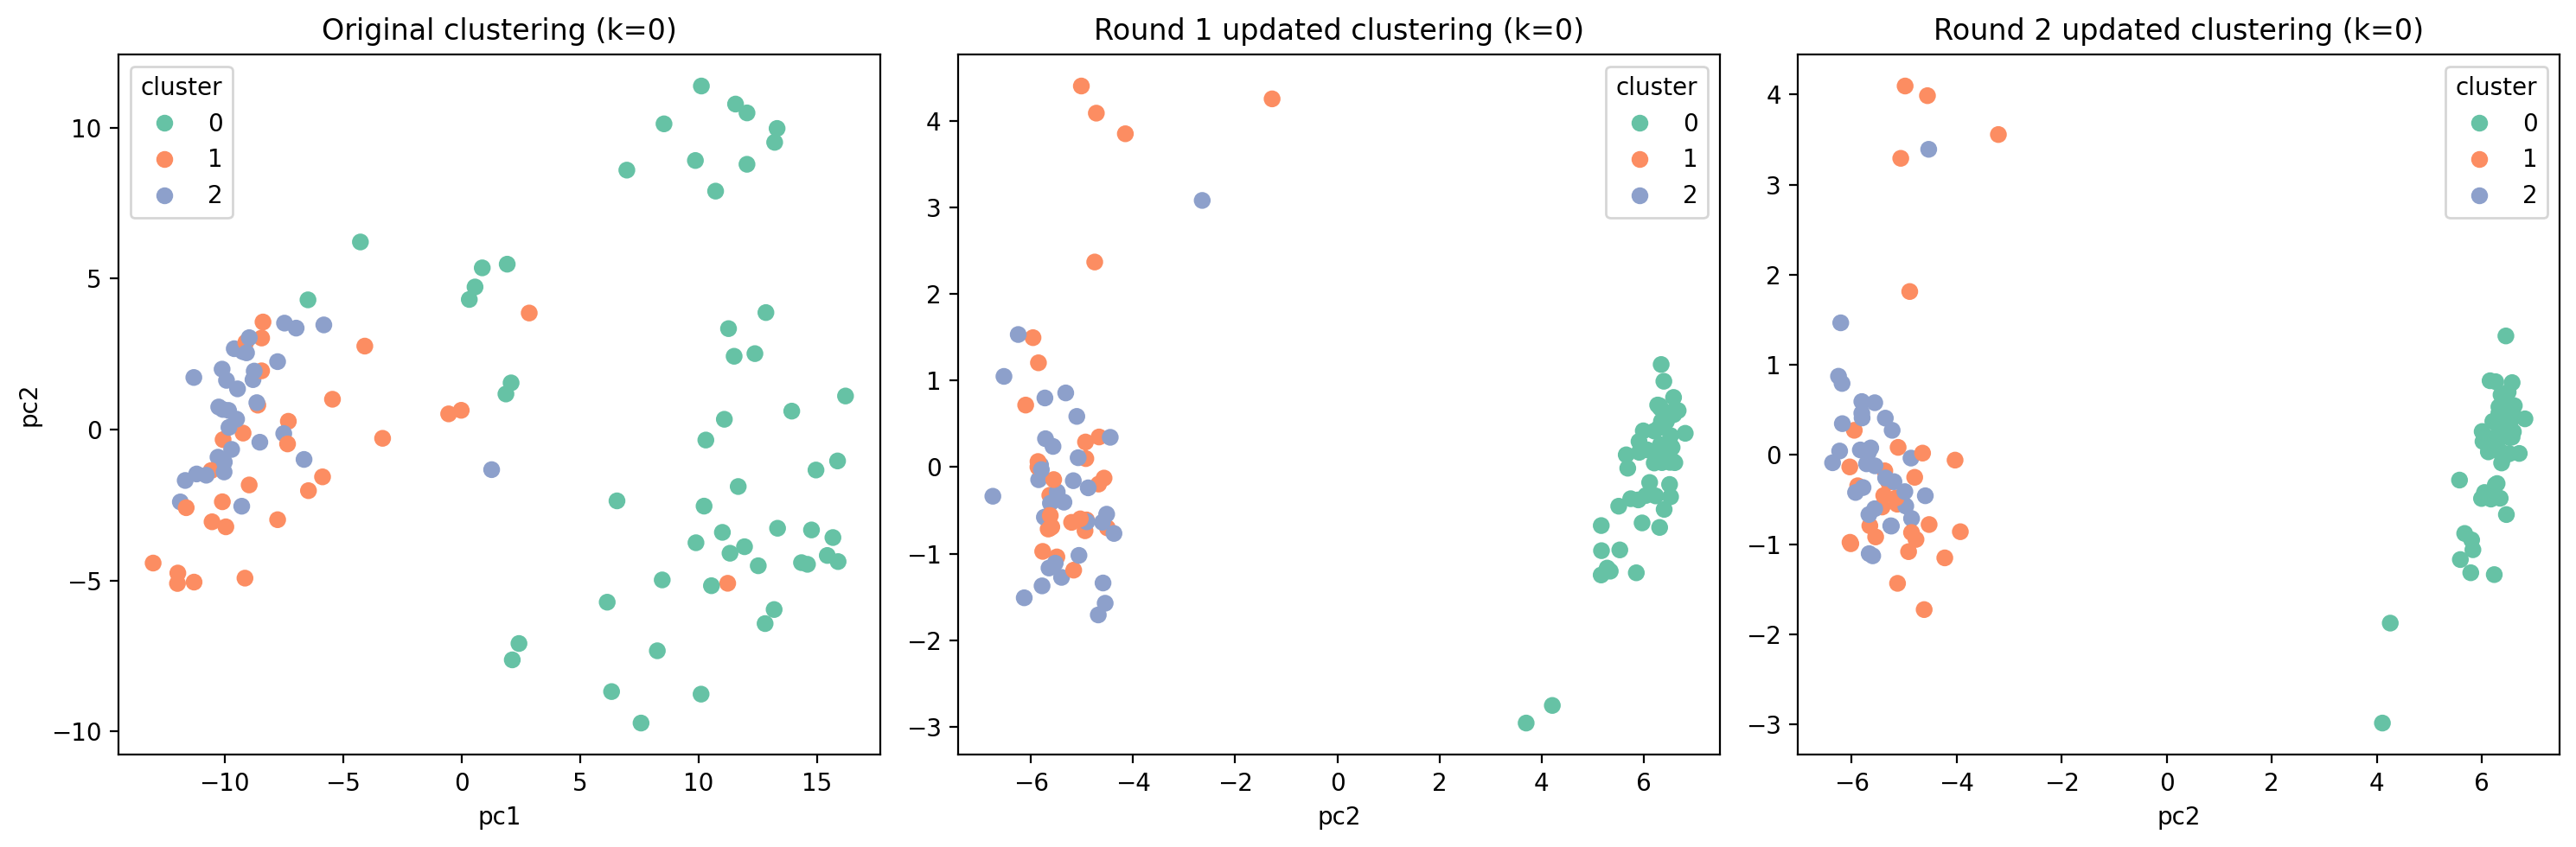

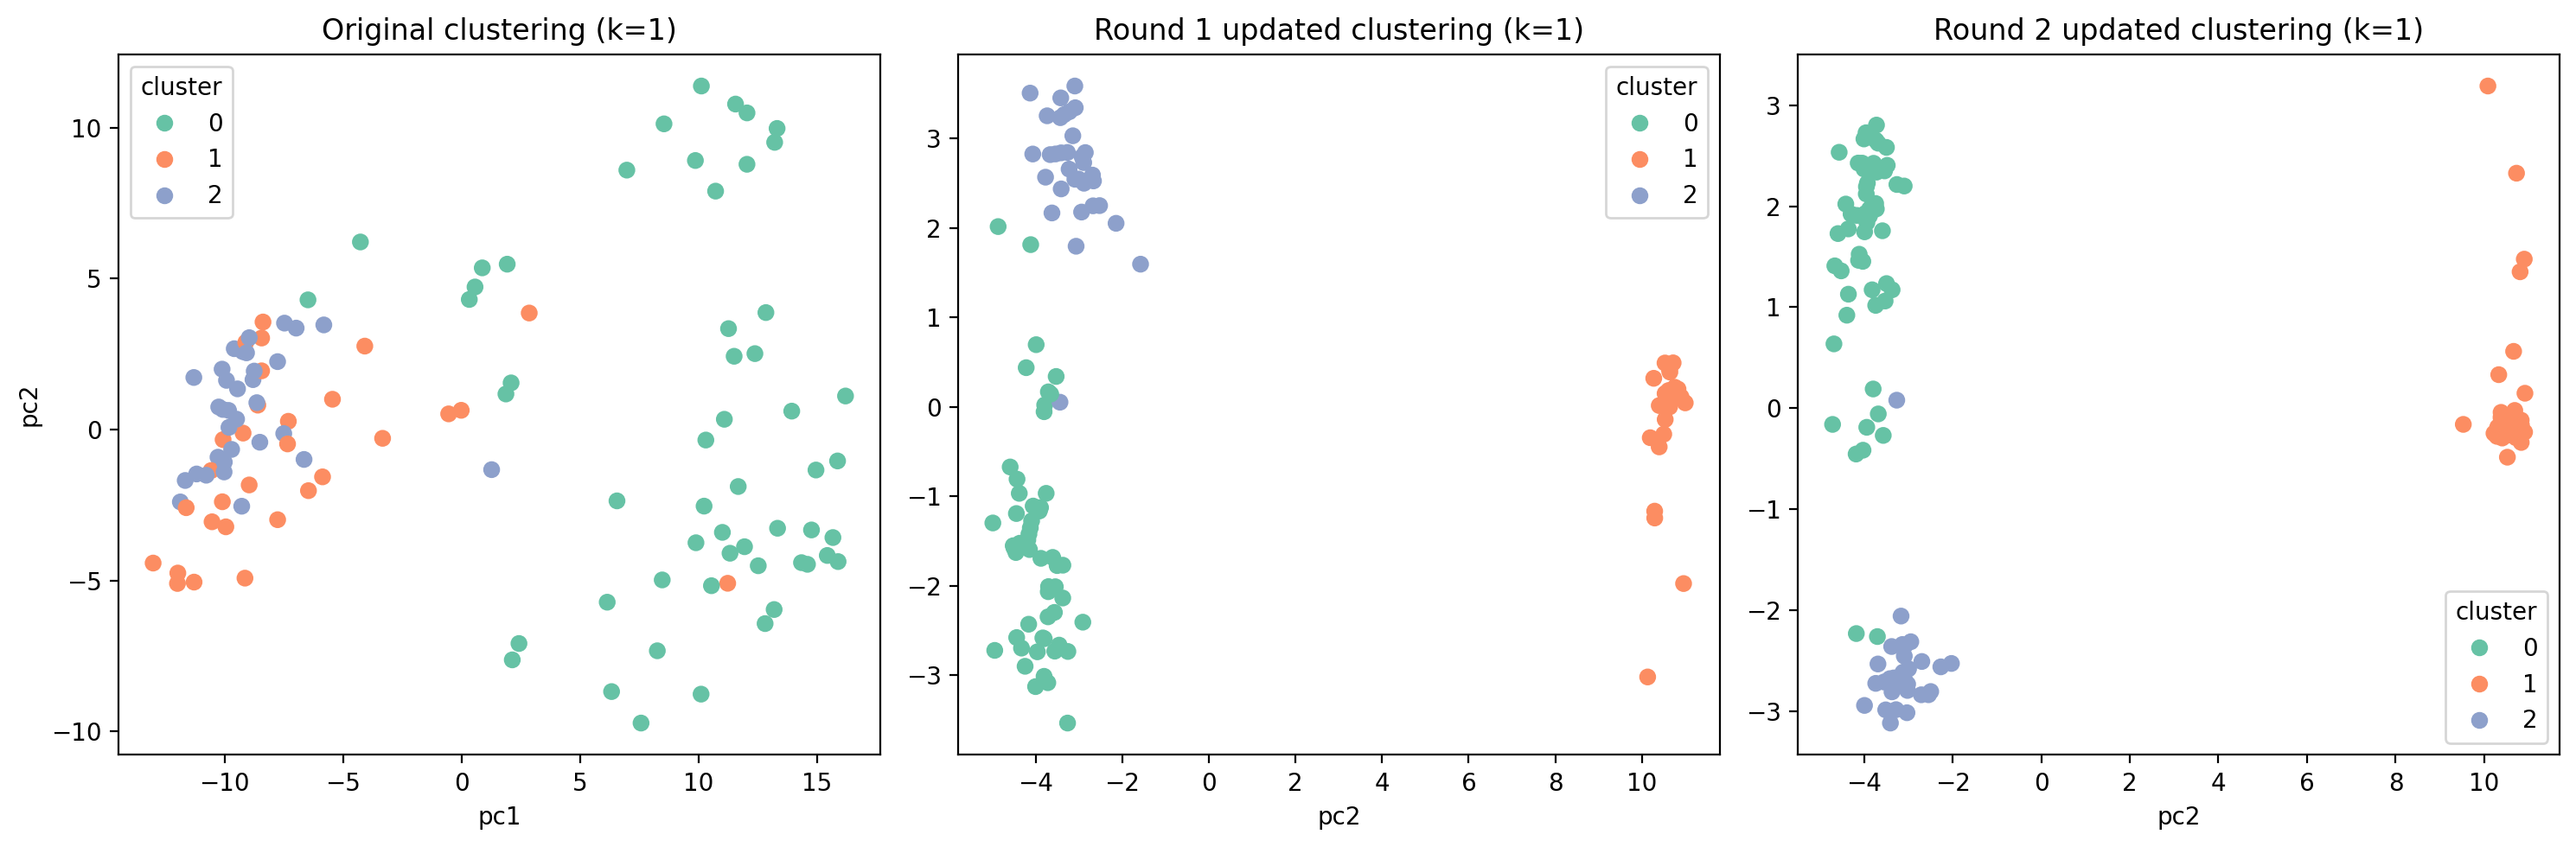

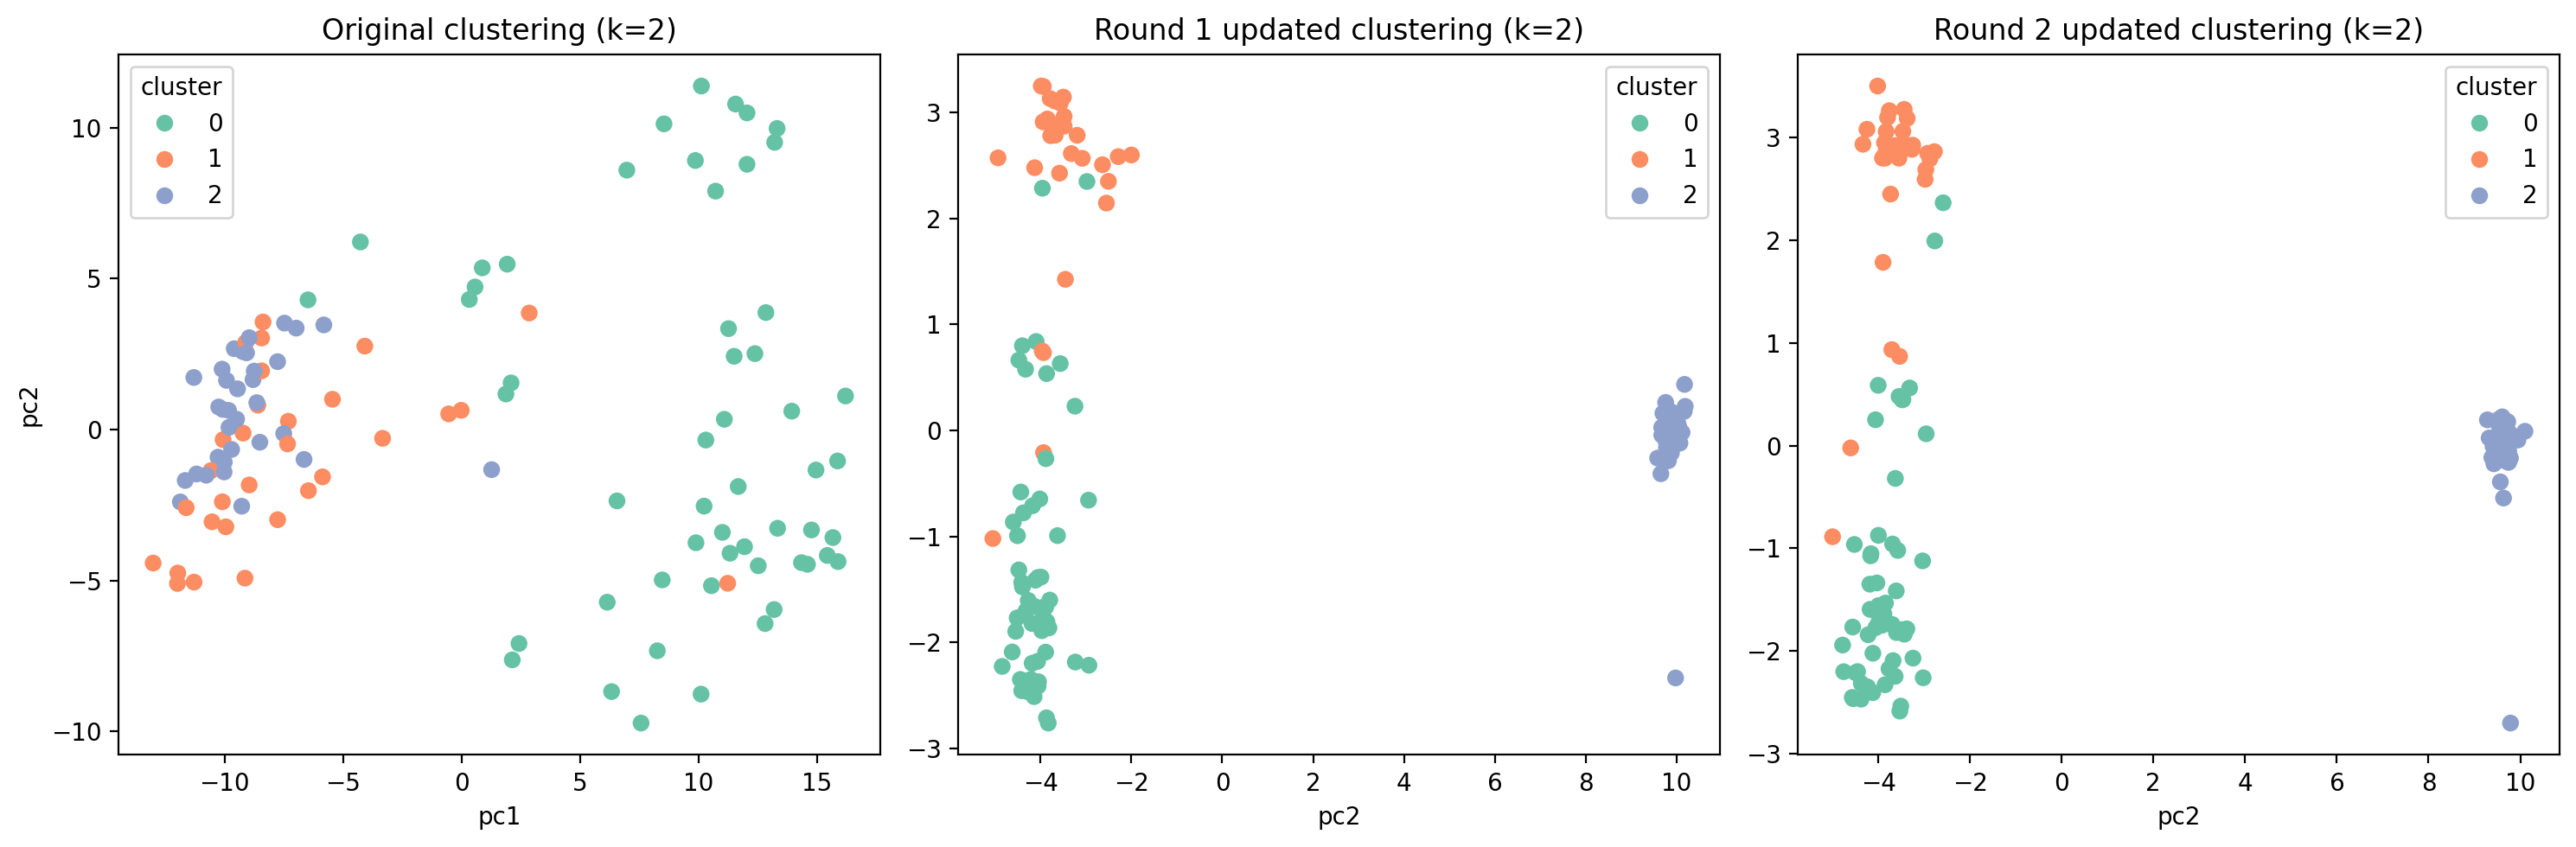

In [21]:
for k in range(K):
    plot_c_PCA_latent(c_train, c_latent_list, c_meta_hist, n_rounds, legend_title='cluster', k=k, 
                      plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_c_latent_k{k}.png')

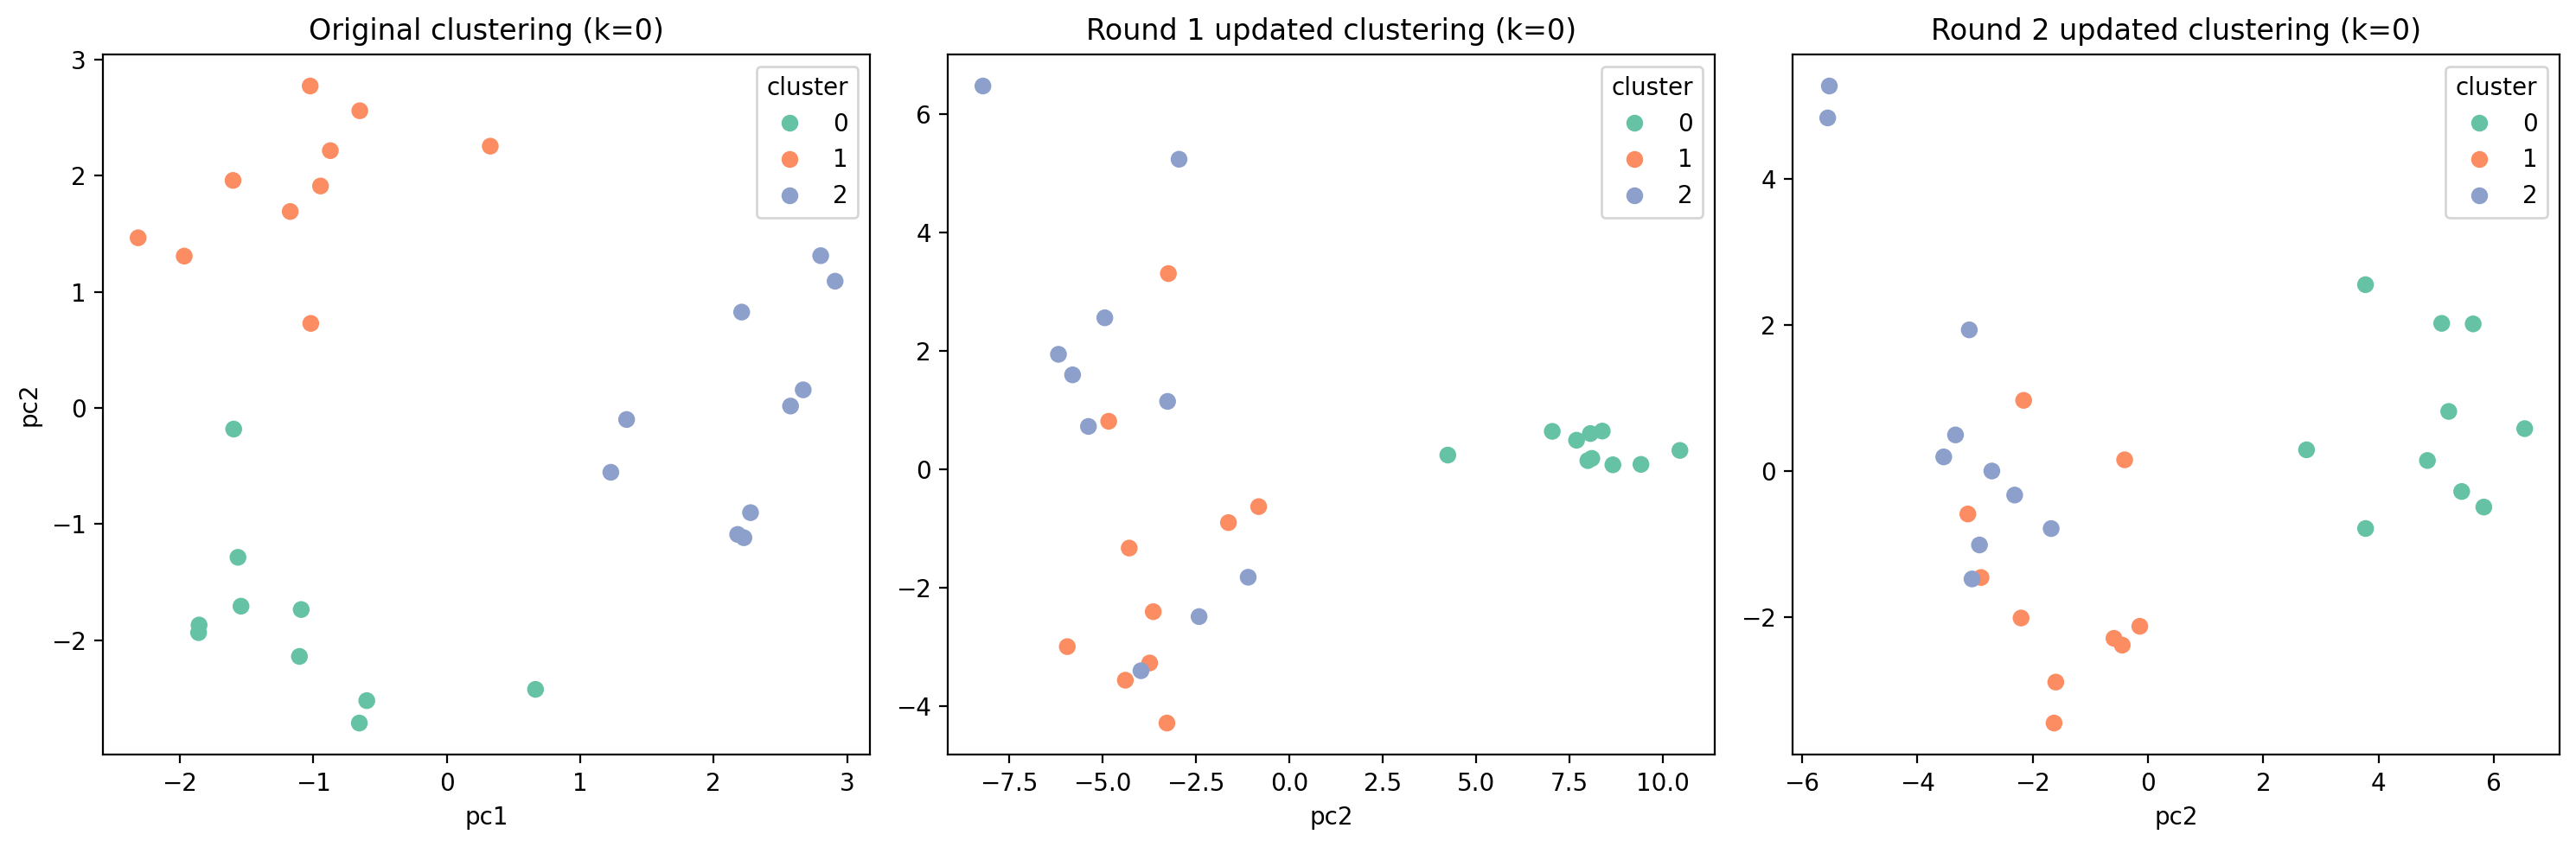

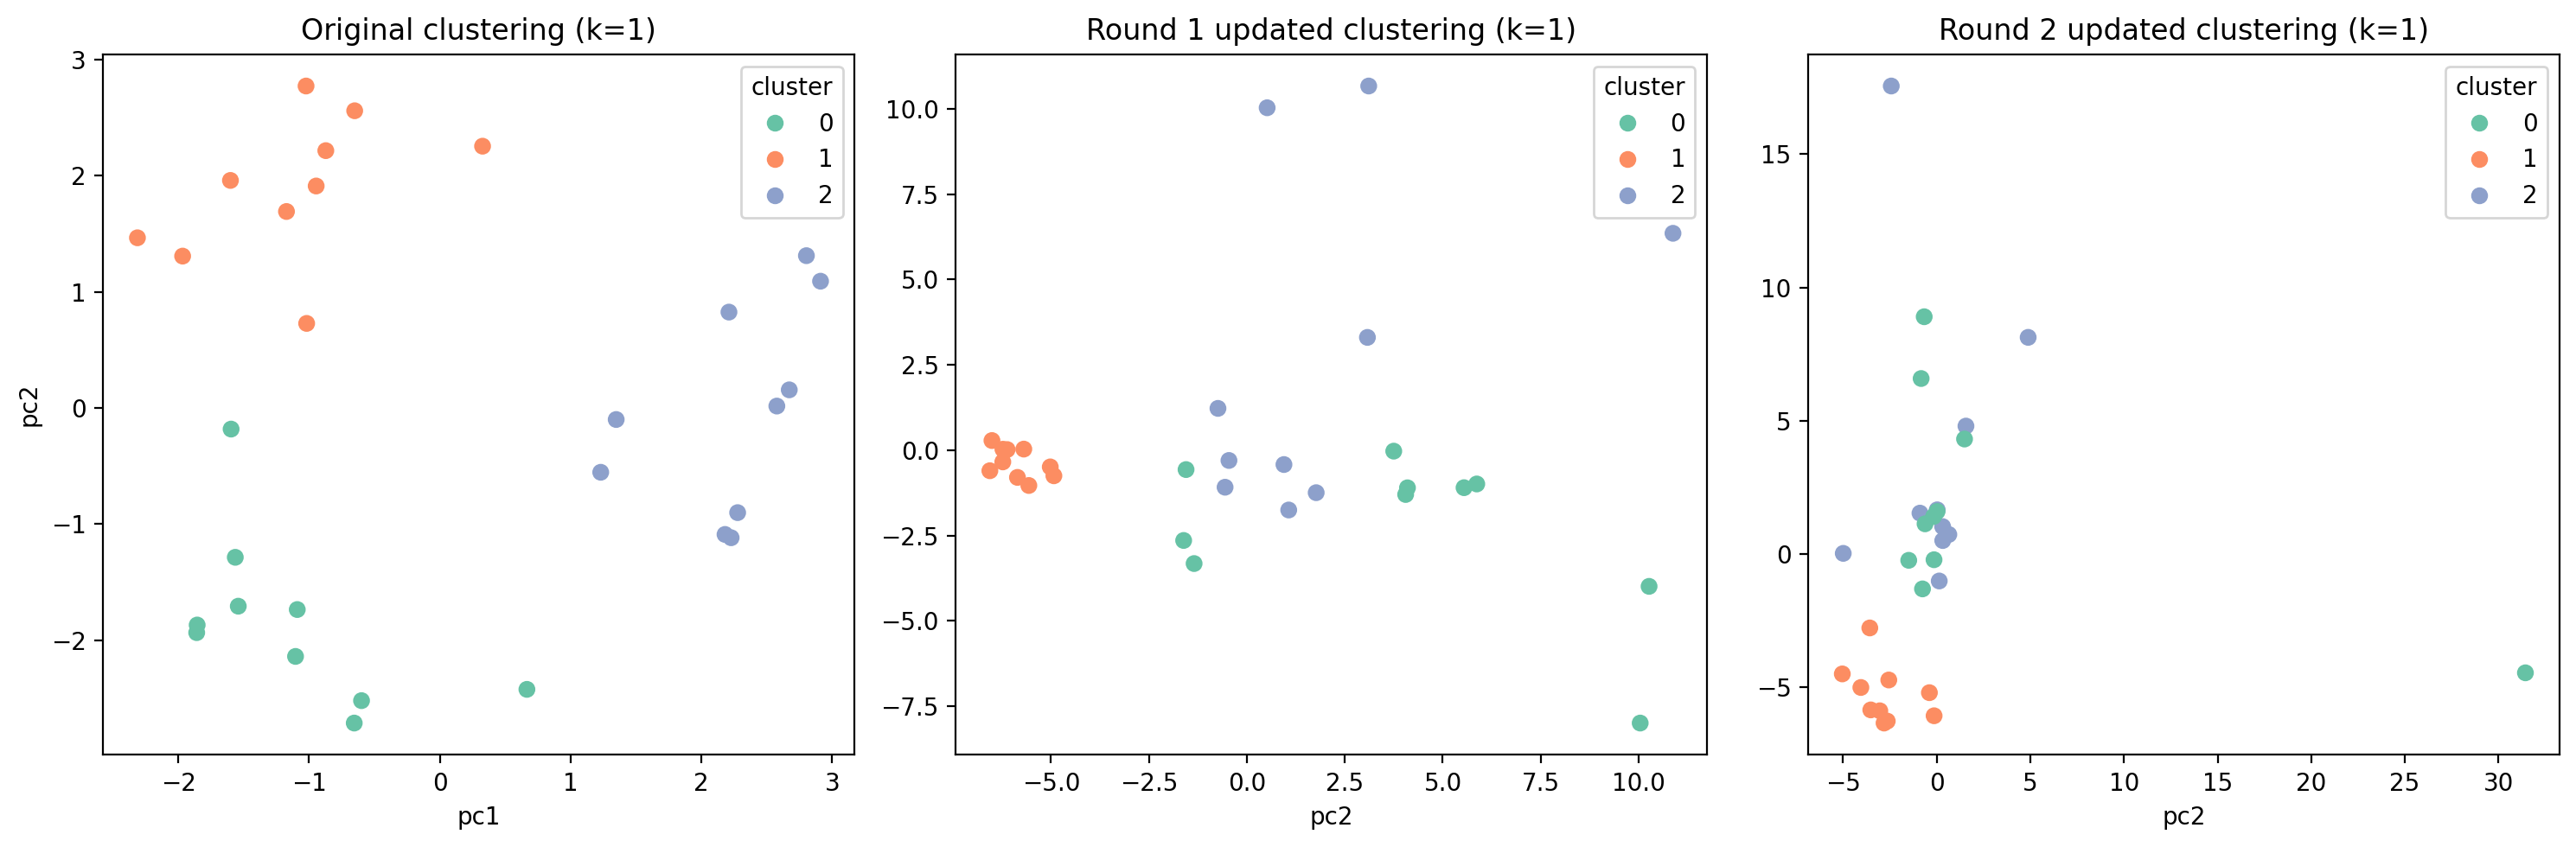

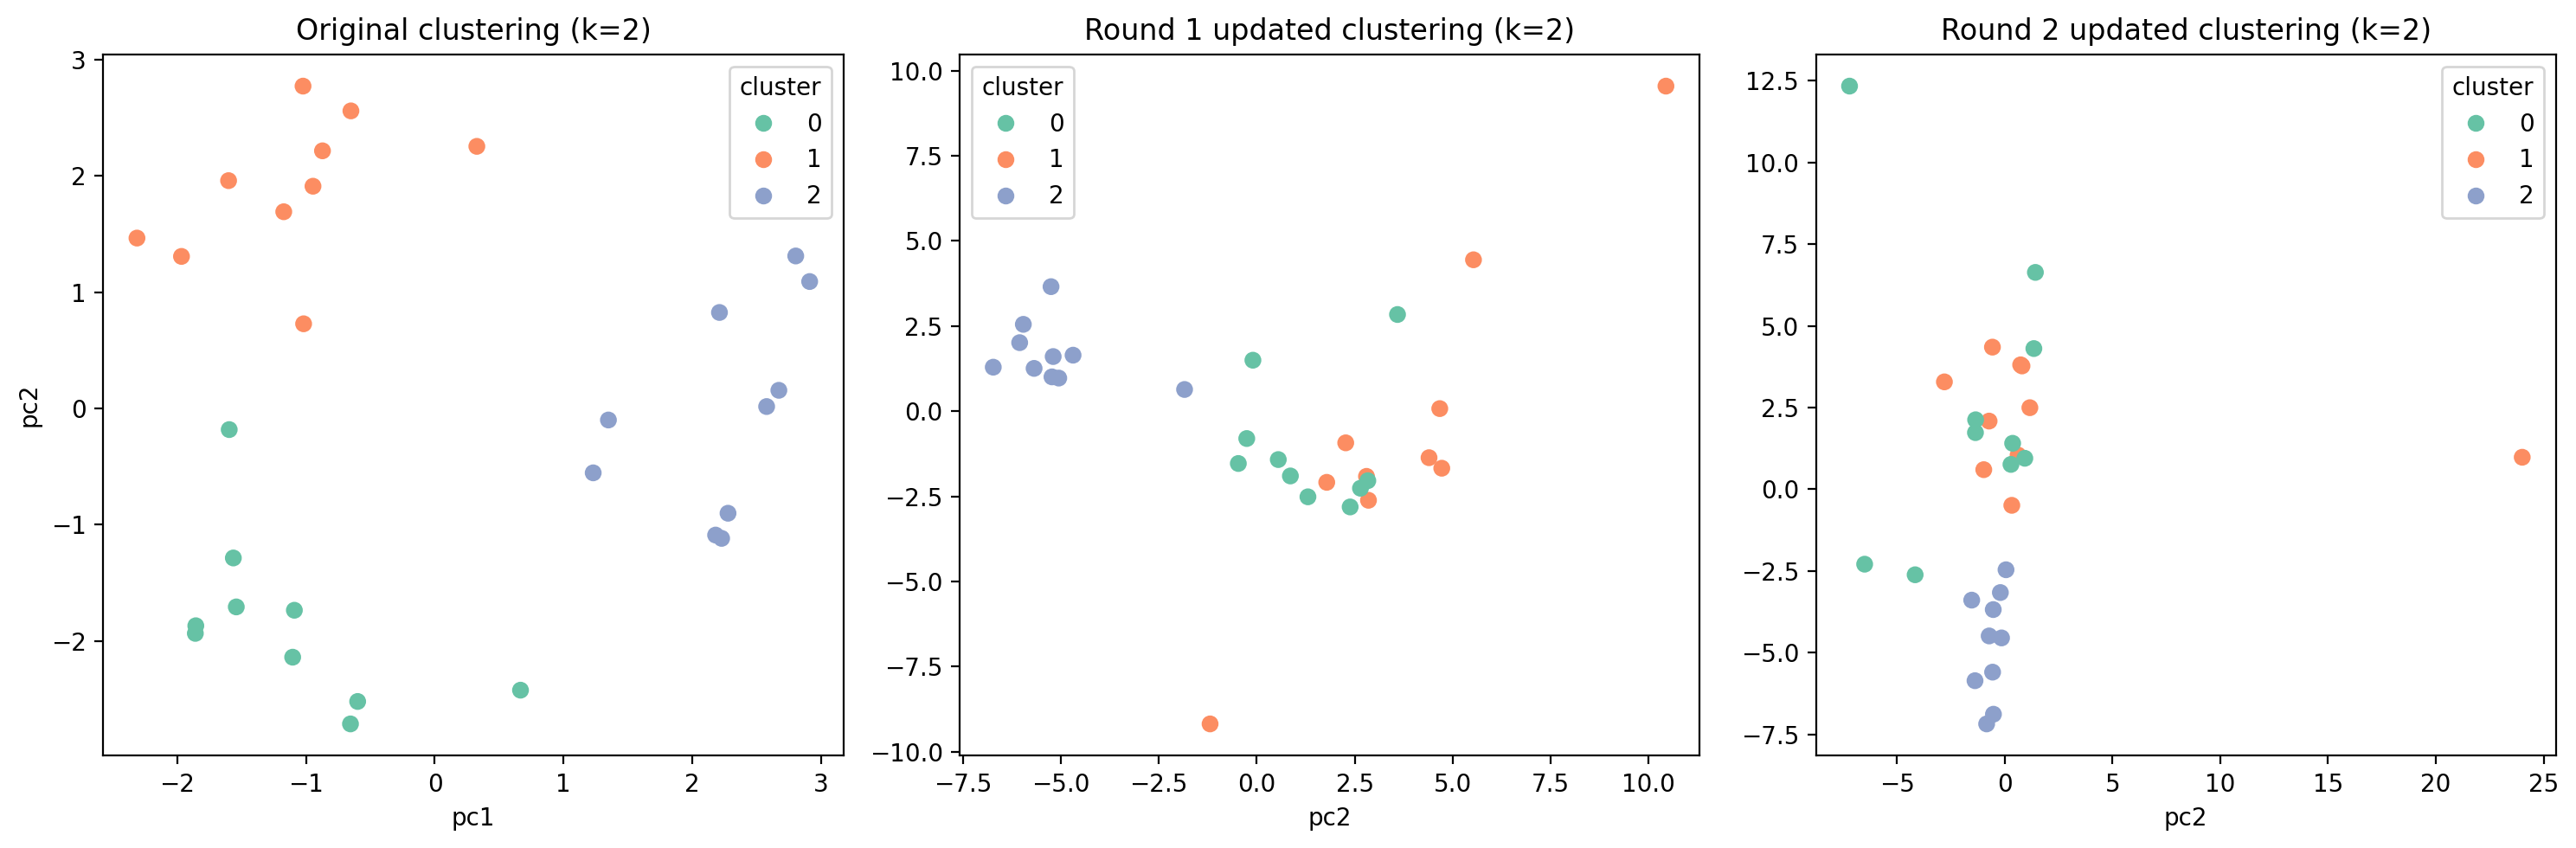

In [22]:
for k in range(K):
    plot_d_PCA_latent(d_data, d_latent_list, d_sens_hist, n_rounds, legend_title='cluster', k=k, 
                      plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_d_latent_k{k}.png')

In [24]:
losses_train_hist_list

[[[    epoch  loss_train  loss_test  vae_loss_train  vae_loss_test  \
   0       0   23.430474  16.463143       19.287358      16.462964   
   1       1   16.221039  14.172017       16.220680      14.171928   
   2       2   15.107176  14.007808       15.106932      14.007783   
   3       3   14.700778  12.819416       14.700619      12.819373   
   4       4   14.187746  12.709162       14.187502      12.709155   
   ..    ...         ...        ...             ...            ...   
   95     95   12.684813  11.437270       12.684798      11.437250   
   96     96   12.688405  11.393845       12.688395      11.393842   
   97     97   12.546569  11.108942       12.546566      11.108936   
   98     98   12.520280  11.253027       12.520277      11.253024   
   99     99   12.520331  11.239709       12.520328      11.239707   
   
       recon_loss_train  recon_loss_test  kld_train   kld_test  \
   0          16.811528        15.746722   8.322139  11.338472   
   1          15.932023 

k = 0:
round 0:


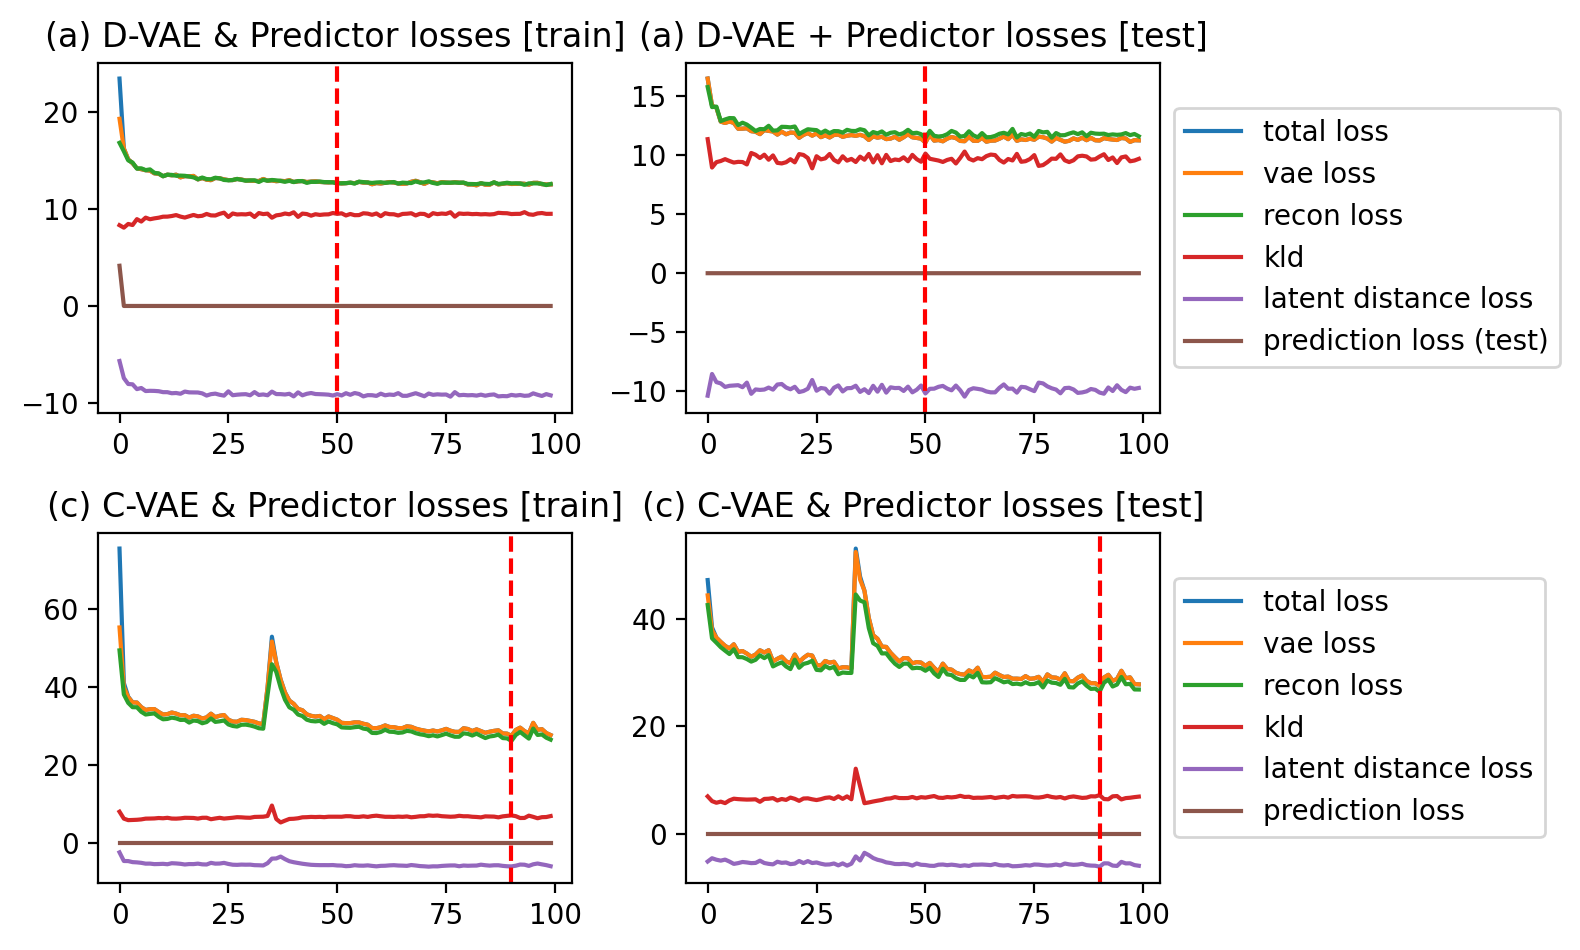

round 1:


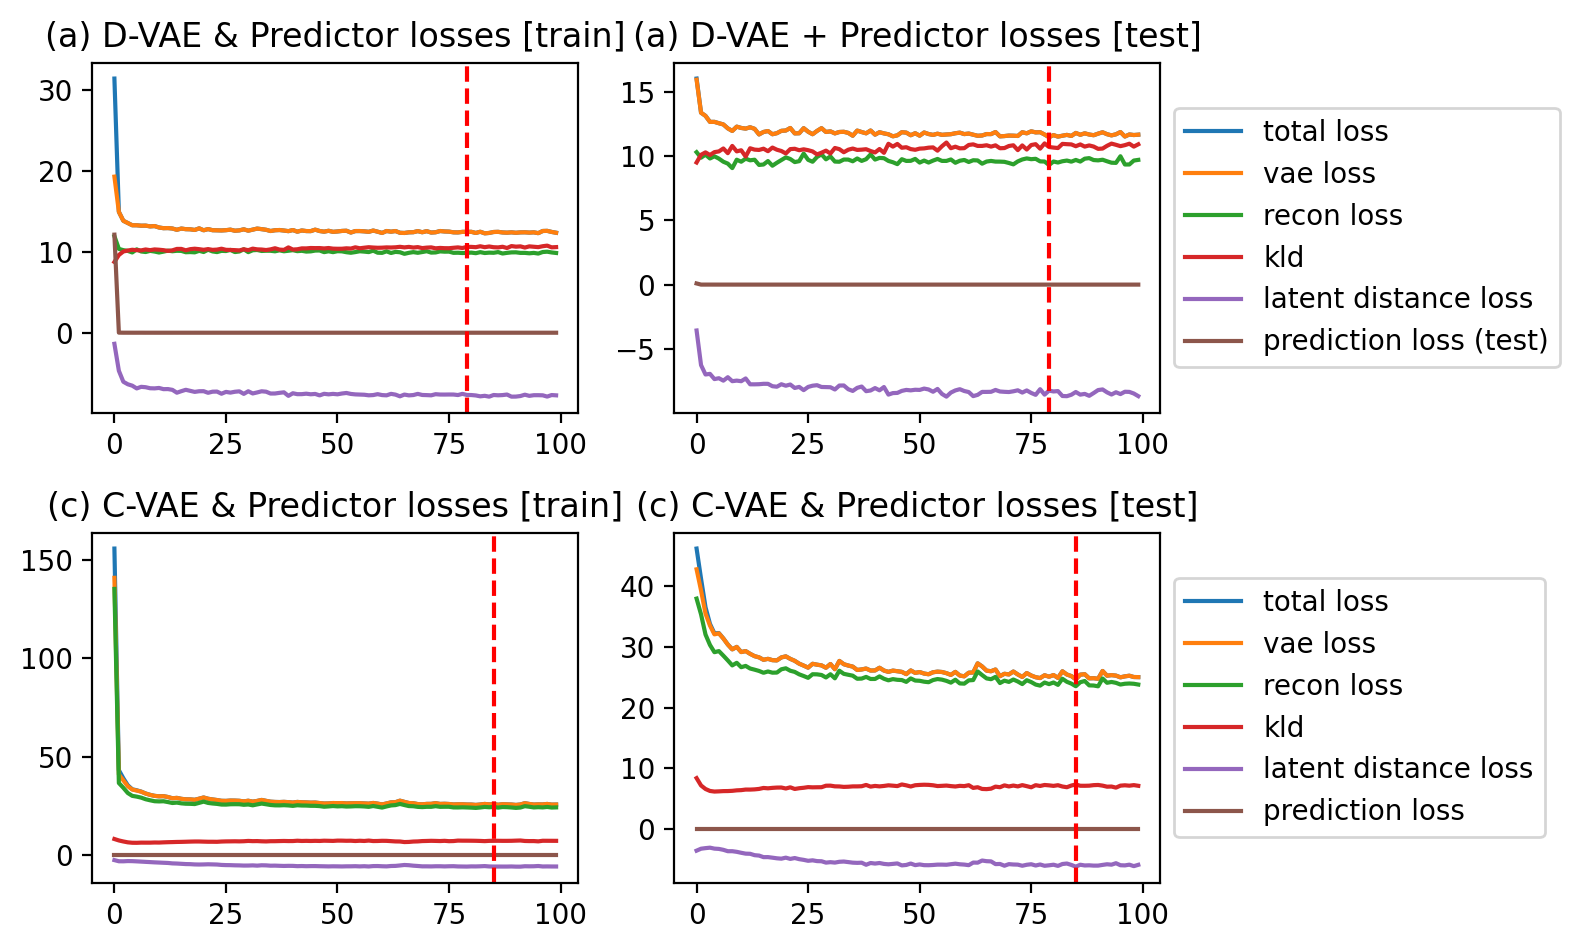

k = 1:
round 0:


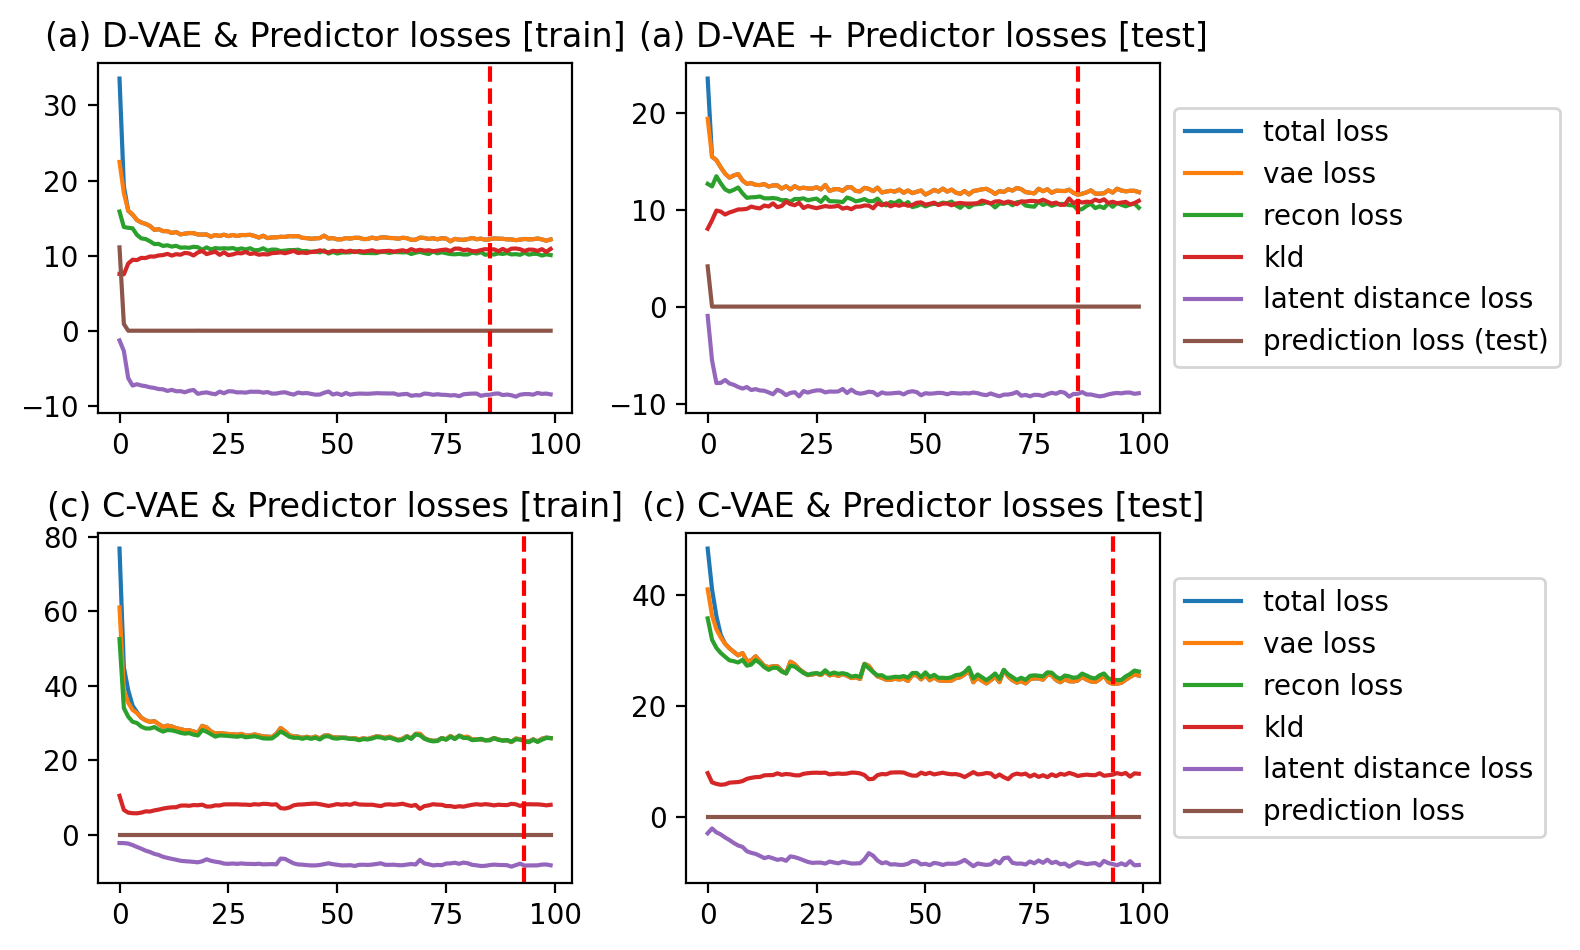

round 1:


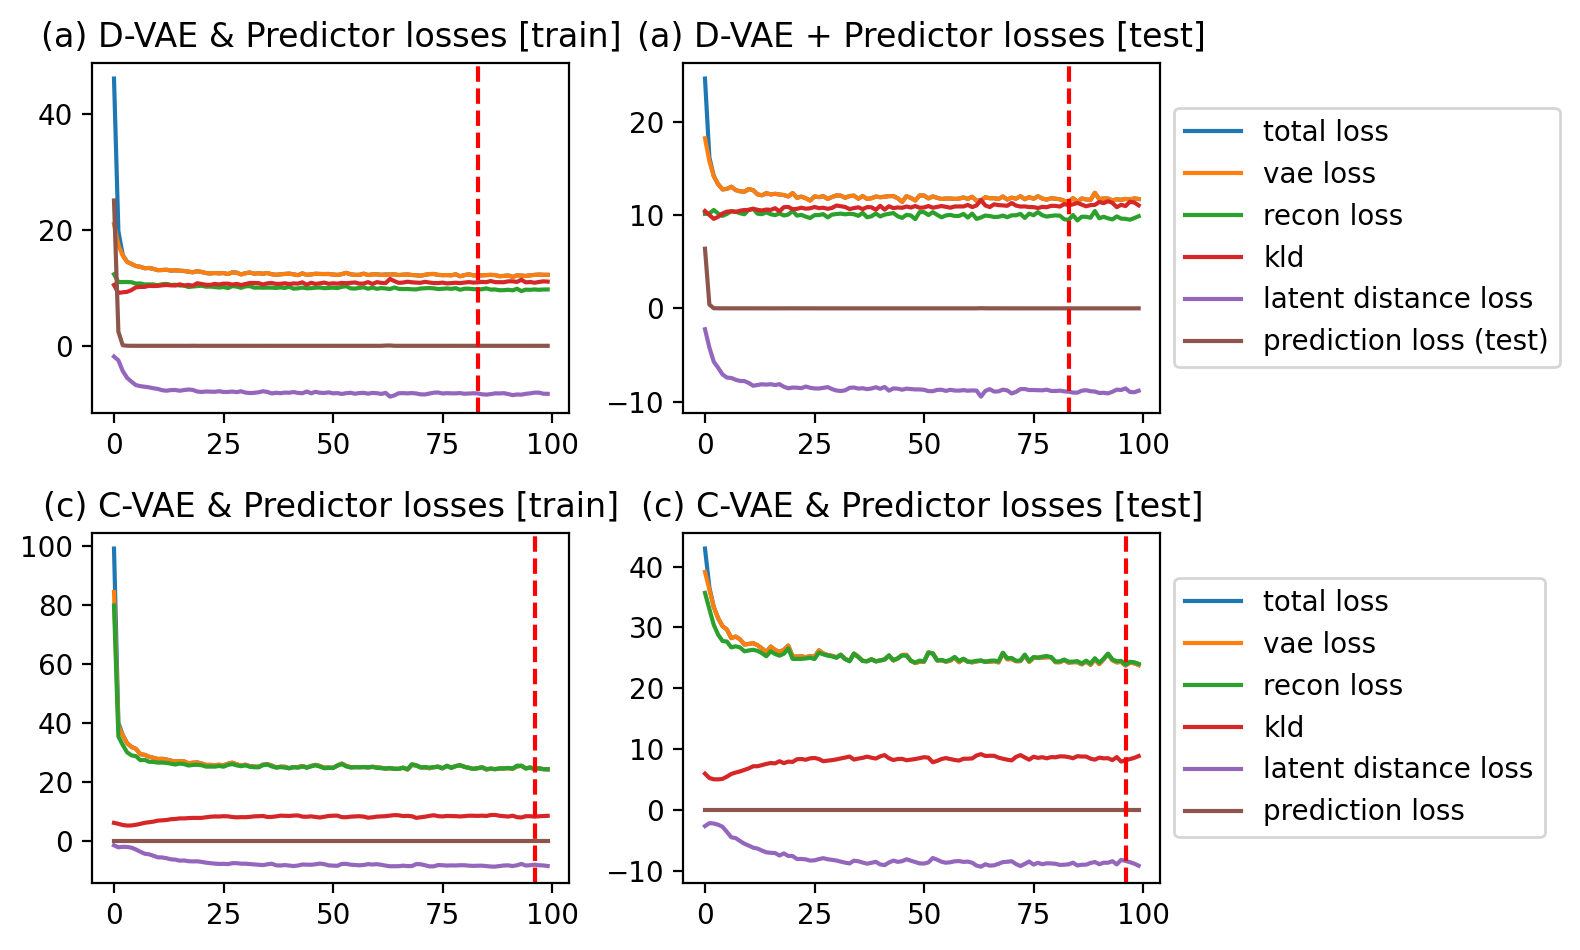

k = 2:
round 0:


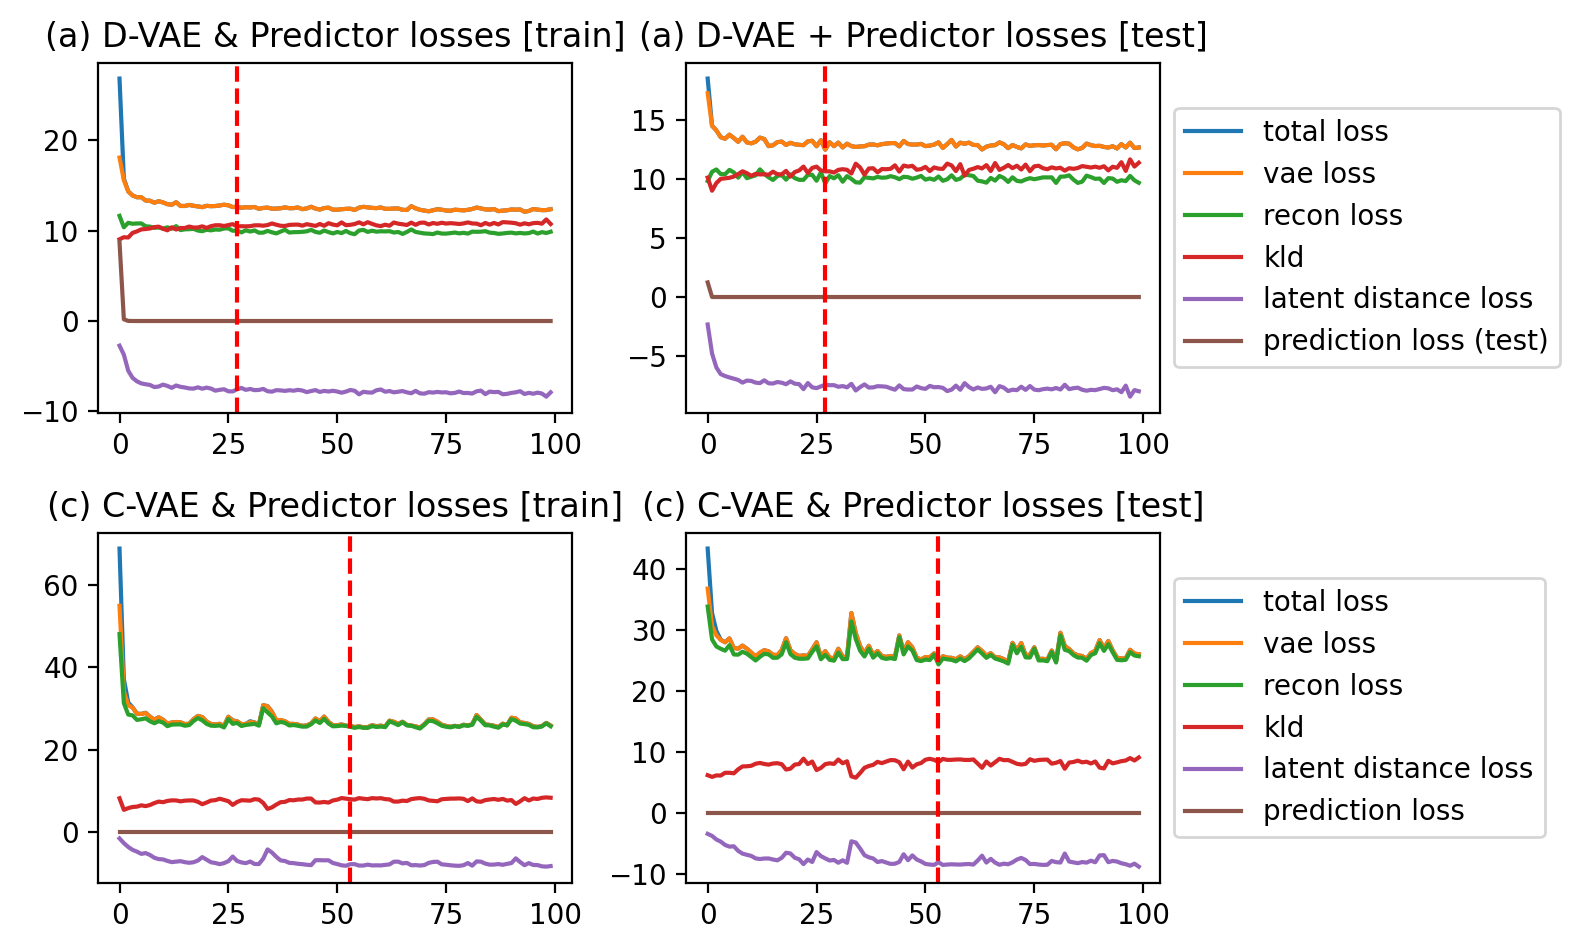

round 1:


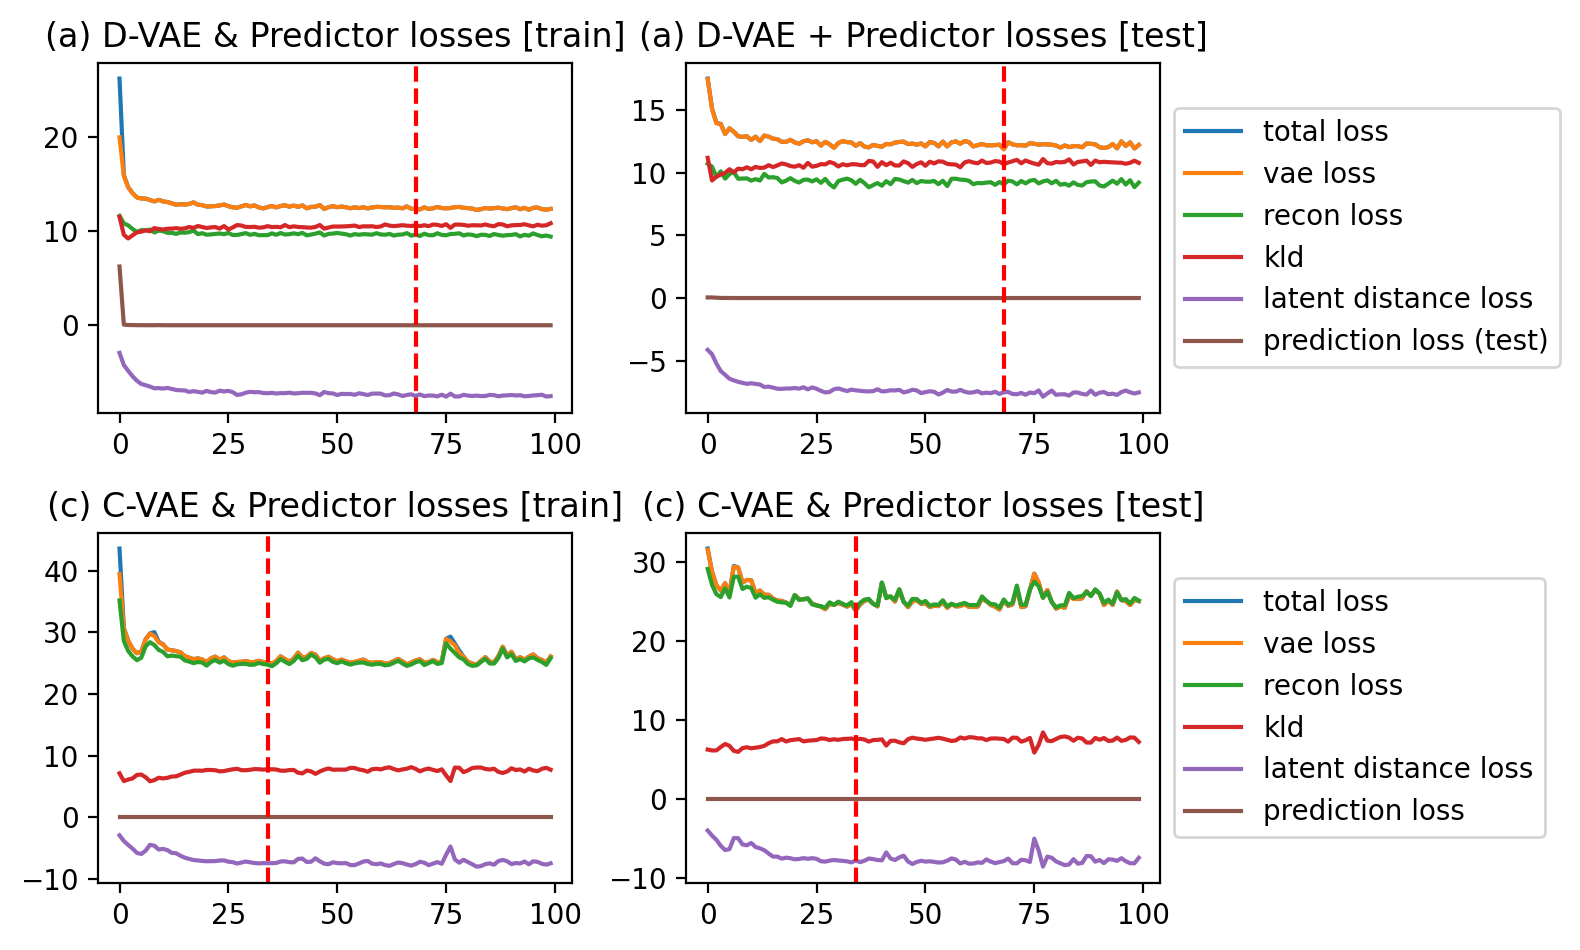

In [23]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[b][k], best_epoch_1round = best_epos_list[b][k],
                                              plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_losses_b{b}_k{k}.png')
        

In [ ]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_predict_training_losses_train_test_2cols(losses_train_hist_list[b][k], best_epoch_1round = best_epos_list[b][k])
        